In [211]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.pylabtools import figsize

from scipy.io import arff
import pandas as pd

import math

from sklearn import preprocessing
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import progressbar

from scipy.stats.stats import pearsonr, kendalltau, spearmanr

import progressbar

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def FirstDerivative(y):
  L = len(y)
  der = np.zeros(L)
  der[0] = 0
  for i in range(1, L):
    der[i] = y[i] - y[i-1]
  return der

In [212]:
def FirstDerivative(y):
    L = len(y)
    x = np.linspace(0,L,L)
    dx = x[1]-x[0]
    dydx = np.gradient(y, dx)
    return dydx

In [213]:
def CalculateHurst(y, a, N_steps):
  hurst = np.zeros(N_steps)
  #progress = progressbar.ProgressBar()
  #for i in progress(range(0, N_steps)):
  for i in range(0, N_steps):
    mx = max(y[0:a*(i+1)])
    mn = min(y[0:a*(i+1)])
    devi = np.std(y[0:a*(i+1)])
    hurst[i] = (mx-mn) / (devi + 1e-18)
    if(math.isnan(hurst[i])):
      print("Error!")
  return hurst

In [214]:
import progressbar

def GenerateNewFeatures(X, start_offset, w_size, a):
  N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
  L = N_steps * w_size
  N_features = X.shape[1]
  X_new = np.zeros((L, N_features))
  N_steps_window = int(np.floor(w_size / a))
  progress = progressbar.ProgressBar()
  for i in progress(range(0, N_features)):
    for j in range(0, N_steps):
      hurst = CalculateHurst(X[start_offset+j*w_size:start_offset+(j+1)*w_size, i], a, N_steps_window)
      #print(len(X.iloc[i*w_size:(i+1)*w_size, j]))
      #i_hurst = integral(hurst - np.mean(hurst))
      X_new[j*w_size:(j+1)*w_size, i] = FirstDerivative(hurst)
  return X_new

## Traffic characterization 

### Scenario A: 
The objective of this scenario is to characterize encrypted traffic with VPN identification,
e.g. we will distinguish between voice-calls (VOIP) and voice-calls tunneled through VPN (VPN-VOIP).
As a result we will have 14 different types of traffic, 7 regular types of encrypted traffic and 7 VPN types
of traffic. In this Scenario we do the characterization in two steps. First, we distinguish between VPN and
Non-VPN traffic and then we characterize each type of traffic separately (VPN and Non-VPN). In order to
do this, we have divided our dataset in two different datasets: one with regular encrypted traffic flows and
the other one with VPN traffic flows. 

### Scenario B: 
In this Scenario, we use a mixed dataset to do the characterization in one step. The input of
our classifier is regular encrypted traffic and VPN traffic, and as output we have the same 14 different
categories 

In [215]:
def common_way(data):
    data = arff.loadarff(data)
    df = pd.DataFrame(data[0])
    
    X = df.drop('class1', axis=1)
    y = df["class1"]

    lb = preprocessing.LabelBinarizer()
    y_bin = np.zeros(len(y))

    for i in range(0, len(y)):
      if y[i] == b'Non-VPN':
        y_bin[i] = 0
      if y[i] == b'VPN':
        y_bin[i] = 1 

    scaler = MinMaxScaler()
    X = np.nan_to_num(X)
    scaler.fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)
    
    return X_train, X_test, y_train, y_test

In [216]:
X_tr15, X_t15, y_tr15, y_t15 = common_way ('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-15s-VPN.arff')

In [217]:
def random_search_cv(X_train, y_train):
    forest = RandomForestClassifier(n_estimators=110, 
                               bootstrap = True,
                               max_features = 'sqrt',
                               max_depth= 10,
                               random_state = 42)

    # Number of trees used in the boosting process
    n_estimators = [80, 85, 90, 95, 100, 110, 120, 130]

    # Maximum depth of each tree
    max_depth = [4, 5, 6, 7]

    # Minimum number of samples per leaf
    min_samples_leaf = [3, 4, 5, 6]

    # Minimum number of samples to split a node
    min_samples_split = [8, 9, 10, 11, 12]

    # Maximum number of features to consider for making splits
    max_features = ['auto', 'sqrt', 'log2', None]

    # Define the grid of hyperparameters to search
    hyperparameter_grid = {
                           'n_estimators': n_estimators,
                           'max_depth': max_depth,
                           'min_samples_leaf': min_samples_leaf,
                           'min_samples_split': min_samples_split,
                           'max_features': max_features}

    # Set up the random search with 5-fold cross validation
    random_cv = RandomizedSearchCV(estimator=forest,
                                   param_distributions=hyperparameter_grid,
                                   cv=5, n_iter=100, 
                                   scoring = 'neg_mean_absolute_error',
                                   n_jobs = -1, verbose = 1, 
                                   return_train_score = True,
                                   random_state=42)

    random_cv.fit(X_tr15,y_tr15)
    
    return random_cv

In [218]:
random_cv = random_search_cv(X_tr15, X_t15)
final_model = random_cv.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.3min finished


final_model = random_cv.best_estimator_
final_pred = final_model.predict(X_test)

print('Final model performance on the test set: Accuracy = %0.4f.' % accuracy_score(y_test, final_pred))

In [219]:
def model_quality(X_train_full, X_test_full, y_train_full, y_test_full, model, N_est=100):
    RF_pr = []
    RF_rc = []
    RF_f1 = []
    RF_acc = []

    progress = progressbar.ProgressBar()
    for i in progress(range(1, N_est)):
        model.n_estimators = i
        model.fit(X_train_full, y_train_full)
        RF_pr.append(precision_score(y_test_full, model.predict(X_test_full), average="macro"))
        RF_rc.append(recall_score(y_test_full, model.predict(X_test_full), average="macro"))
        RF_f1.append(f1_score(y_test_full, model.predict(X_test_full), average="macro"))
        RF_acc.append (accuracy_score(y_test_full, model.predict(X_test_full)))

    print ("Pr",max(RF_pr)) 
    print ("Rc",max(RF_rc))
    print ("F1",max(RF_f1))
    print ("Acc",max(RF_acc))
    
    return max(RF_pr), max(RF_rc), max(RF_f1),max(RF_acc)

In [220]:
q15_common = model_quality(X_tr15, X_t15, y_tr15, y_t15, final_model)

Pr 0.8253614377308123
Rc 0.8187669076654831
F1 0.8197506750817052
Acc 0.8214285714285714


In [221]:
X_tr30, X_t30, y_tr30, y_t30 = common_way ('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-30s-VPN.arff')
random_cv = random_search_cv(X_tr30, X_t30)
final_model = random_cv.best_estimator_
q30_common = model_quality(X_tr30, X_t30, y_tr30, y_t30, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


Pr 0.8242158288325716
Rc 0.8115072958789056
F1 0.8130758809299474
Acc 0.816196542311192


In [222]:
X_tr60, X_t60, y_tr60, y_t60 = common_way ('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-60s-VPN.arff')
random_cv = random_search_cv(X_tr60, X_t60)
final_model = random_cv.best_estimator_
q60_common = model_quality(X_tr60, X_t60, y_tr60, y_t60, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


Pr 0.7858672156101831
Rc 0.7620510729592902
F1 0.7647123054686771
Acc 0.7748657357679914


In [223]:
X_tr120, X_t120, y_tr120, y_t120 = common_way ('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-120s-VPN.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_common = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


Pr 0.7896571042209988
Rc 0.7871277838417494
F1 0.7877032464178907
Acc 0.7888717156105101


## Scenario A1 - AGM

In [224]:
def CalculateGM(y, a, N_steps, p):
    gm = np.zeros(N_steps)
    #progress = progressbar.ProgressBar()
    #for i in progress(range(0, N_steps)):
    #gm = np.power((1/(N_steps+1))*np.sum(np.power (y[0:N_steps], p)), 1/p)
        
    for i in range(0, N_steps):
        gm[i] = np.power((1/(i+1))*np.sum(np.power (y[0:i], p)), 1/p)
        if(math.isnan(gm[i])):
            print("Error!")
    
    return gm

In [225]:
def GenerateNewFeaturesGM(X, start_offset, w_size, a, p):
    N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
    L = N_steps * w_size
    #L = N_steps
    N_features = X.shape[1]
    X_new = np.zeros((L, N_features))
    print (X_new.shape)
    N_steps_window = int(np.floor(w_size / a))
    progress = progressbar.ProgressBar()
    for i in progress(range(0, N_features)):
        for j in range(0, N_steps):
            gm = CalculateGM(X[start_offset+j*w_size:start_offset+(j+1)*w_size, i], a, N_steps_window, p)
            #print(len(X.iloc[i*w_size:(i+1)*w_size, j]))
            #i_hurst = integral(hurst - np.mean(hurst))
            #X_new[j*w_size:(j+1)*w_size, i] = FirstDerivative(hurst)
            X_new[j*w_size:(j+1)*w_size, i] = gm
    return X_new

In [226]:
def agm_way(data, w_size = 500, a = 1, start_offset = 0, p = 0.1):
    data = arff.loadarff(data)
    df = pd.DataFrame(data[0])
    
    X = df.drop('class1', axis=1)
    y = df["class1"]

    lb = preprocessing.LabelBinarizer()
    y_bin = np.zeros(len(y))

    for i in range(0, len(y)):
      if y[i] == b'Non-VPN':
        y_bin[i] = 0
      if y[i] == b'VPN':
        y_bin[i] = 1 

    scaler = MinMaxScaler()
    X = np.nan_to_num(X)
    scaler.fit(X)
    X = scaler.transform(X)
    
    X_new_full = GenerateNewFeaturesGM(X, start_offset, w_size, a, p)
    
    N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
    X_train, X_test, y_train, y_test = train_test_split(X_new_full, 
                                                        y_bin[0:N_steps*w_size], 
                                                        test_size = 0.3, shuffle=True, 
                                                        stratify=y_bin[0:N_steps*w_size])

    return X_train, X_test, y_train, y_test

In [227]:
X_tr15, X_t15, y_tr15, y_t15 = agm_way('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-15s-VPN.arff')
random_cv = random_search_cv(X_tr15, X_t15)
final_model = random_cv.best_estimator_
q15_agmA1 = model_quality(X_tr15, X_t15, y_tr15, y_t15, final_model)

(18500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.9min finished


Pr 0.9847528423056571
Rc 0.9841747310678994
F1 0.9844419216576925
Acc 0.9845045045045046


In [228]:
X_tr30, X_t30, y_tr30, y_t30 = agm_way ('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-30s-VPN.arff')
random_cv = random_search_cv(X_tr30, X_t30)
final_model = random_cv.best_estimator_
q30_agmA1 = model_quality(X_tr30, X_t30, y_tr30, y_t30, final_model)

(14500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.9min finished


Pr 0.9869703620454056
Rc 0.9858990147783251
F1 0.9863625197727521
Acc 0.9864367816091955


In [229]:
X_tr60, X_t60, y_tr60, y_t60 = agm_way ('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-60s-VPN.arff')
random_cv = random_search_cv(X_tr60, X_t60)
final_model = random_cv.best_estimator_
q60_agmA1 = model_quality(X_tr60, X_t60, y_tr60, y_t60, final_model)

(15500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.9min finished


Pr 0.9719046121519861
Rc 0.966222784543991
F1 0.9685150205357675
Acc 0.9690322580645161


In [230]:
X_tr120, X_t120, y_tr120, y_t120 = agm_way ('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-120s-VPN.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_agmA1 = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

(10500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.9min finished


Pr 0.9921385432749069
Rc 0.991906198216993
F1 0.9920198301394245
Acc 0.9920634920634921


# Comparison AGM vs Common way

In [231]:
x = ["15", "30", "60", "120"]
comm_acc = [q15_common[3], q30_common[3],q60_common[3],q120_common[3]]
agm_acc = [q15_agmA1[3], q30_agmA1[3],q60_agmA1[3],q120_agmA1[3]]

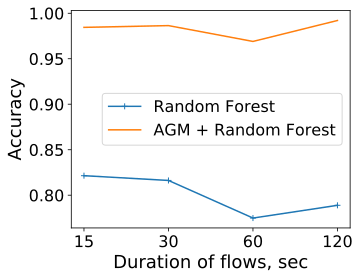

In [232]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
f, ax = plt.subplots(figsize=(5, 4))

ax.plot(x, comm_acc, '+', linestyle='solid', label='Random Forest')
ax.plot(x, agm_acc, '--', linestyle='solid', label='AGM + Random Forest')

plt.xlabel('Duration of flows, sec', size = 18);
plt.ylabel('Accuracy', size = 18);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

ax.legend(prop={'size': 16})
f.savefig("Hurst/AGMAccuracyA1.png", bbox_inches = "tight")

plt.show()

## Application classification (Scenarion A2)

In [233]:
def common_way_A2(data, w_size = 500, a = 1, start_offset = 0, p = 0.1):
    data = arff.loadarff(data)
    df = pd.DataFrame(data[0])
    
    X = df.drop('class1', axis=1)
    y = df["class1"]

    lb = preprocessing.LabelBinarizer()
    y_bin = np.zeros(len(y))

    y_multi = np.zeros(len(y))
    for i in range(0, len(y)):
        if y[i] == b'VPN-BROWSING':
            y_multi[i] = 0
        if y[i] == b'VPN-VOIP':
            y_multi[i] = 1 
        if y[i] == b'VPN-FT':
            y_multi[i] = 2 
        if y[i] == b'VPN-P2P':
            y_multi[i] = 3 
        if y[i] == b'VPN-CHAT':
            y_multi[i] = 4
        if y[i] == b'VPN-MAIL':
            y_multi[i] = 5
        if y[i] == b'VPN-STREAMING':
            y_multi[i] = 6   
            
        if y[i] == b'BROWSING':
            y_multi[i] = 0
        if y[i] == b'VOIP':
            y_multi[i] = 1 
        if y[i] == b'FT':
            y_multi[i] = 2 
        if y[i] == b'P2P':
            y_multi[i] = 3 
        if y[i] == b'CHAT':
            y_multi[i] = 4
        if y[i] == b'MAIL':
            y_multi[i] = 5
        if y[i] == b'STREAMING':
            y_multi[i] = 6 
            
            

    scaler = MinMaxScaler()
    X = np.nan_to_num(X)
    scaler.fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y_multi, 
                                                        test_size = 0.3, shuffle=True, 
                                                        stratify=y_multi)

    return X_train, X_test, y_train, y_test

In [234]:
X_tr15, X_t15, y_tr15, y_t15 = common_way_A2('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-15s-VPN.arff')
random_cv = random_search_cv(X_tr15, X_t15)
final_model = random_cv.best_estimator_
q15_A2vnp = model_quality(X_tr15, X_t15, y_tr15, y_t15, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pr 0.7843003945422219
Rc 0.7566814242202614
F1 0.7620863076403752
Acc 0.7978216473791695


In [235]:
X_tr15, X_t15, y_tr15, y_t15 = common_way_A2('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-15s-NO-VPN.arff')
random_cv = random_search_cv(X_tr15, X_t15)
final_model = random_cv.best_estimator_
q15_A2novnp = model_quality(X_tr15, X_t15, y_tr15, y_t15, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Pr 0.8623461476620287
Rc 0.8043548733465568
F1 0.828721516697434
Acc 0.8884758364312267


In [236]:
X_tr30, X_t30, y_tr30, y_t30 = common_way_A2 ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-30s-VPN.arff')
random_cv = random_search_cv(X_tr30, X_t30)
final_model = random_cv.best_estimator_
q30_A2vnp = model_quality(X_tr30, X_t30, y_tr30, y_t30, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Pr 0.8320645761722201
Rc 0.7559995632702062
F1 0.7813842627185202
Acc 0.8108573890564412


In [237]:
X_tr30, X_t30, y_tr30, y_t30 = common_way_A2 ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-30s-NO-VPN.arff')
random_cv = random_search_cv(X_tr30, X_t30)
final_model = random_cv.best_estimator_
q30_A2novnp = model_quality(X_tr30, X_t30, y_tr30, y_t30, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksant/anaconda3/lib/python3.7/site-packages

Pr 0.875394922086078
Rc 0.6705212203405104
F1 0.7131924373753771
Acc 0.8424855491329479


In [238]:
X_tr60, X_t60, y_tr60, y_t60 = common_way_A2 ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-60s-VPN.arff')
random_cv = random_search_cv(X_tr60, X_t60)
final_model = random_cv.best_estimator_
q60_A2vnp = model_quality(X_tr60, X_t60, y_tr60, y_t60, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pr 0.7629857518178772
Rc 0.6784969899635439
F1 0.6929790473445802
Acc 0.7693416626621816


In [239]:
X_tr60, X_t60, y_tr60, y_t60 = common_way_A2 ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-60s-NO-VPN.arff')
random_cv = random_search_cv(X_tr60, X_t60)
final_model = random_cv.best_estimator_
q60_A2novnp = model_quality(X_tr60, X_t60, y_tr60, y_t60, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Pr 0.817160464562001
Rc 0.7363167196134613
F1 0.7576659936944979
Acc 0.8348873348873349


In [240]:
X_tr120, X_t120, y_tr120, y_t120 = common_way_A2 ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-120s-VPN.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_A2vnp = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Pr 0.8134254435700231
Rc 0.649410512951723
F1 0.6713740497365706
Acc 0.7727810650887574


In [241]:
X_tr120, X_t120, y_tr120, y_t120 = common_way_A2 ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-120s-NO-VPN.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_A2novnp = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Pr 0.8672425531628077
Rc 0.7102279623940035
F1 0.7604081634222938
Acc 0.8635187580853816


In [242]:
def agm_way(data, w_size = 500, a = 1, start_offset = 0, p = 0.1):
    data = arff.loadarff(data)
    df = pd.DataFrame(data[0])
    
    X = df.drop('class1', axis=1)
    y = df["class1"]

    lb = preprocessing.LabelBinarizer()
    y_bin = np.zeros(len(y))

    y_multi = np.zeros(len(y))
    for i in range(0, len(y)):
        if y[i] == b'VPN-BROWSING':
            y_multi[i] = 0
        if y[i] == b'VPN-VOIP':
            y_multi[i] = 1 
        if y[i] == b'VPN-FT':
            y_multi[i] = 2 
        if y[i] == b'VPN-P2P':
            y_multi[i] = 3 
        if y[i] == b'VPN-CHAT':
            y_multi[i] = 4
        if y[i] == b'VPN-MAIL':
            y_multi[i] = 5
        if y[i] == b'VPN-STREAMING':
            y_multi[i] = 6   
            
        if y[i] == b'BROWSING':
            y_multi[i] = 0
        if y[i] == b'VOIP':
            y_multi[i] = 1 
        if y[i] == b'FT':
            y_multi[i] = 2 
        if y[i] == b'P2P':
            y_multi[i] = 3 
        if y[i] == b'CHAT':
            y_multi[i] = 4
        if y[i] == b'MAIL':
            y_multi[i] = 5
        if y[i] == b'STREAMING':
            y_multi[i] = 6 

    scaler = MinMaxScaler()
    X = np.nan_to_num(X)
    scaler.fit(X)
    X = scaler.transform(X)
    
    X_new_full = GenerateNewFeaturesGM(X, start_offset, w_size, a, p)
    
    N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
    X_train, X_test, y_train, y_test = train_test_split(X_new_full, 
                                                        y_multi[0:N_steps*w_size], 
                                                        test_size = 0.3, shuffle=True, 
                                                        stratify=y_multi[0:N_steps*w_size])

    return X_train, X_test, y_train, y_test

In [243]:
X_tr15, X_t15, y_tr15, y_t15 = agm_way('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-15s-VPN.arff')
random_cv = random_search_cv(X_tr15, X_t15)
final_model = random_cv.best_estimator_
q15_agmA2vnp = model_quality(X_tr15, X_t15, y_tr15, y_t15, final_model)

(9500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


Pr 0.9779413898577928
Rc 0.9678575781270095
F1 0.9719238818106863
Acc 0.9789473684210527


In [244]:
X_tr15, X_t15, y_tr15, y_t15 = agm_way('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-15s-NO-VPN.arff')
random_cv = random_search_cv(X_tr15, X_t15)
final_model = random_cv.best_estimator_
q15_agmA2novnp = model_quality(X_tr15, X_t15, y_tr15, y_t15, final_model)

(8500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Pr 0.9804096113123294
Rc 0.9854416506609527
F1 0.982839346829458
Acc 0.9901960784313726


In [245]:
X_tr30, X_t30, y_tr30, y_t30 = agm_way ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-30s-VPN.arff')
random_cv = random_search_cv(X_tr30, X_t30)
final_model = random_cv.best_estimator_
q30_agmA2vnp = model_quality(X_tr30, X_t30, y_tr30, y_t30, final_model)

(7500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Pr 0.9870106054984761
Rc 0.9840443704722388
F1 0.9851704249667829
Acc 0.988


In [246]:
X_tr30, X_t30, y_tr30, y_t30 = agm_way ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-30s-NO-VPN.arff')
random_cv = random_search_cv(X_tr30, X_t30)
final_model = random_cv.best_estimator_
q30_agmA2novnp = model_quality(X_tr30, X_t30, y_tr30, y_t30, final_model)

(6500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Pr 0.989662046029377
Rc 0.9895333878430329
F1 0.98950804828798
Acc 0.9876923076923076


In [247]:
X_tr60, X_t60, y_tr60, y_t60 = agm_way ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-60s-VPN.arff')
random_cv = random_search_cv(X_tr60, X_t60)
final_model = random_cv.best_estimator_
q60_agmA2vnp = model_quality(X_tr60, X_t60, y_tr60, y_t60, final_model)

(6500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Pr 0.9847761264393554
Rc 0.9843299140687544
F1 0.9836019147177165
Acc 0.9871794871794872


In [248]:
X_tr60, X_t60, y_tr60, y_t60 = agm_way ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-60s-NO-VPN.arff')
random_cv = random_search_cv(X_tr60, X_t60)
final_model = random_cv.best_estimator_
q60_agmA2novnp = model_quality(X_tr60, X_t60, y_tr60, y_t60, final_model)

(8500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Pr 0.9601211267492343
Rc 0.9598390736602154
F1 0.9598598550208691
Acc 0.9784313725490196


In [249]:
X_tr120, X_t120, y_tr120, y_t120 = agm_way ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-120s-VPN.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_agmA2vnp = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

(5500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Pr 0.9888816706295707
Rc 0.9732172899364018
F1 0.9802598467617896
Acc 0.9890909090909091


In [250]:
X_tr120, X_t120, y_tr120, y_t120 = agm_way ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-120s-NO-VPN.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_agmA2novnp = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

(5000, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Pr 0.9718500819952017
Rc 0.9808890624743046
F1 0.9760530034971435
Acc 0.986


# A2: Comparison AGM vs Common way

In [251]:
x = ["15", "30", "60", "120"]
comm_acc_vpn = [q15_A2vnp[3], q30_A2vnp[3],q60_A2vnp[3],q120_A2vnp[3]]
comm_acc_novpn = [q15_A2novnp[3], q30_A2novnp[3],q60_A2novnp[3],q120_A2novnp[3]]
agm_acc_a2_vpn = [q15_agmA2vnp[3], q30_agmA2vnp[3],q60_agmA2vnp[3],q120_agmA2vnp[3]]
agm_acc_a2_novpn = [q15_agmA2novnp[3], q30_agmA2novnp[3],q60_agmA2novnp[3],q120_agmA2novnp[3]]


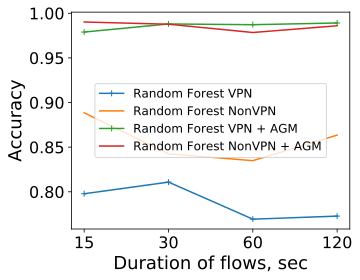

In [252]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
f, ax = plt.subplots(figsize=(5, 4))

ax.plot(x, comm_acc_vpn, '+', linestyle='solid', label='Random Forest VPN')
ax.plot(x, comm_acc_novpn, '--', linestyle='solid', label='Random Forest NonVPN')

ax.plot(x, agm_acc_a2_vpn, '+', linestyle='solid', label='Random Forest VPN + AGM')
ax.plot(x, agm_acc_a2_novpn, '--', linestyle='solid', label='Random Forest NonVPN + AGM')

plt.xlabel('Duration of flows, sec', size = 18);
plt.ylabel('Accuracy', size = 18);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

ax.legend(prop={'size': 12})
f.savefig("Hurst/AGMAccuracyA2.png", bbox_inches = "tight")

plt.show()

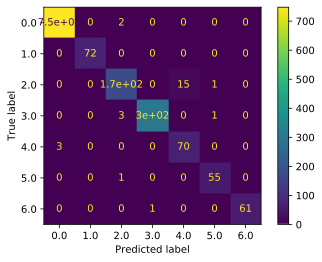

In [253]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(final_model, X_t120, y_t120)
plt.show()  

### Mean presicion and accuracy

In [297]:
comm_acc_A2 = q15_A2vnp[3] + q30_A2vnp[3]+q60_A2vnp[3]+q120_A2vnp[3]+q15_A2novnp[3]+ q30_A2novnp[3]+q60_A2novnp[3]+q120_A2novnp[3]
agm_acc_a2 = q15_agmA2vnp[3]+ q30_agmA2vnp[3]+q60_agmA2vnp[3]+q120_agmA2vnp[3]+q15_agmA2novnp[3]+ q30_agmA2novnp[3]+q60_agmA2novnp[3]+q120_agmA2novnp[3]

print (comm_acc_A2/8)
print (agm_acc_a2/8)

0.8225211553404301
0.9856921904205186


In [299]:
comm_pr_A2 = q15_A2vnp[0] + q30_A2vnp[0]+q60_A2vnp[0]+q120_A2vnp[0]+q15_A2novnp[0]+ q30_A2novnp[0]+q60_A2novnp[0]+q120_A2novnp[0]
agm_pr_a2 = q15_agmA2vnp[0]+ q30_agmA2vnp[0]+q60_agmA2vnp[0]+q120_agmA2vnp[0]+q15_agmA2novnp[0]+ q30_agmA2novnp[0]+q60_agmA2novnp[0]+q120_agmA2novnp[0]

print (comm_pr_A2/8)
print (agm_pr_a2/8)

0.8268650316969072
0.9800815823139171


## Original feature vs AGM feature 

In [254]:
data = arff.loadarff('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-15s-VPN.arff')
df = pd.DataFrame(data[0])

In [255]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [256]:
X.head(1)

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,97590.739583,267600.198443,1871488.0,1.983656e+06,2195089.0,183219.697914,1234883.0,1420565.0,1523088.0,161096.539275


In [257]:
dur = X["duration"]

In [258]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

In [259]:
w_size = 500
a = 1
start_offset = 0
p = 0.1
X_new_full = GenerateNewFeaturesGM(X, start_offset, w_size, a, p)

(18500, 23)


100% |########################################################################|


In [260]:
dur_agm = X_new_full[:,0]

In [261]:
X_new_full[:,0].shape

(18500,)

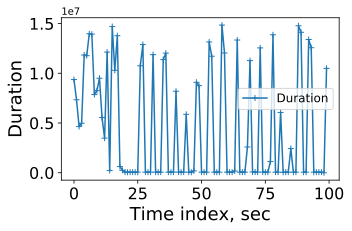

In [303]:
f, ax = plt.subplots(figsize=(5, 3))

ax.plot(dur[:100], '+', linestyle='solid', label='Duration')
#ax.plot(x, comm_acc_novpn, '--', linestyle='solid', label='Random Forest NonVPN')

plt.xlabel('Time index, sec', size = 18);
plt.ylabel('Duration', size = 18);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

ax.legend(prop={'size': 12})
f.savefig("Hurst/AGM-noAGM0.png", bbox_inches = "tight")

plt.show()

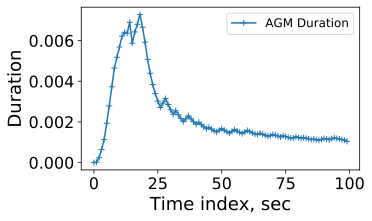

In [302]:
f, ax = plt.subplots(figsize=(5, 3))

ax.plot(dur_agm[:100], '+', linestyle='solid', label='AGM Duration')
#ax.plot(x, comm_acc_novpn, '--', linestyle='solid', label='Random Forest NonVPN')

plt.xlabel('Time index, sec', size = 18);
plt.ylabel('Duration', size = 18);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

ax.legend(prop={'size': 12})
f.savefig("Hurst/AGM-noAGM1.png", bbox_inches = "tight")

plt.show()

## B2 Scenario

In [280]:
data = arff.loadarff('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-15s.arff')
#data = arff.loadarff('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-15s-AllinOne.arff')
df = pd.DataFrame(data[0])

In [281]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [282]:
y.value_counts()

b'VOIP'             2826
b'BROWSING'         2500
b'VPN-BROWSING'     2500
b'VPN-VOIP'         2271
b'VPN-FT'           1932
b'VPN-CHAT'         1196
b'FT'               1018
b'P2P'              1000
b'VPN-P2P'           928
b'CHAT'              890
b'VPN-MAIL'          491
b'STREAMING'         482
b'VPN-STREAMING'     475
b'MAIL'              249
Name: class1, dtype: int64

In [283]:
X_tr15, X_t15, y_tr15, y_t15 = common_way_A2('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-15s.arff')
random_cv = random_search_cv(X_tr15, X_t15)
final_model = random_cv.best_estimator_
q15_Bvnp = model_quality(X_tr15, X_t15, y_tr15, y_t15, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished


Pr 0.7767114694500148
Rc 0.7127266892153378
F1 0.7294772537447339
Acc 0.7981520966595593


In [284]:
X_tr30, X_t30, y_tr30, y_t30 = common_way_A2 ('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-30s.arff')
random_cv = random_search_cv(X_tr30, X_t30)
final_model = random_cv.best_estimator_
q30_Bvnp = model_quality(X_tr30, X_t30, y_tr30, y_t30, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


Pr 0.804603986572879
Rc 0.6929834549159607
F1 0.7179167648138248
Acc 0.7832120109190173


In [288]:
X_tr60, X_t60, y_tr60, y_t60 = common_way_A2 ('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-60s.arff')
random_cv = random_search_cv(X_tr60, X_t60)
final_model = random_cv.best_estimator_
q60_Bvnp = model_quality(X_tr60, X_t60, y_tr60, y_t60, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


Pr 0.7689446323840096
Rc 0.6400073690592732
F1 0.6615647445821474
Acc 0.7540279269602578


In [289]:
X_tr120, X_t120, y_tr120, y_t120 = common_way_A2 ('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-120s.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_Bvnp = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


Pr 0.8380288824781733
Rc 0.6044853032890755
F1 0.6546306651993097
Acc 0.7672333848531685


######  B2 AGM

In [290]:
X_tr15, X_t15, y_tr15, y_t15 = agm_way('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-15s.arff')
random_cv = random_search_cv(X_tr15, X_t15)
final_model = random_cv.best_estimator_
q15_agmBvnp = model_quality(X_tr15, X_t15, y_tr15, y_t15, final_model)

(18500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.1min finished


Pr 0.9656849882592533
Rc 0.959445478652092
F1 0.9612404196846562
Acc 0.9760360360360361


In [291]:
X_tr30, X_t30, y_tr30, y_t30 = agm_way ('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-30s.arff')
random_cv = random_search_cv(X_tr30, X_t30)
final_model = random_cv.best_estimator_
q30_agmBvnp = model_quality(X_tr30, X_t30, y_tr30, y_t30, final_model)

(14500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished


Pr 0.9665148820339725
Rc 0.9711216297802449
F1 0.9683065428835722
Acc 0.9744827586206897


In [292]:
X_tr60, X_t60, y_tr60, y_t60 = agm_way ('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-60s.arff')
random_cv = random_search_cv(X_tr60, X_t60)
final_model = random_cv.best_estimator_
q60_agmBvnp = model_quality(X_tr60, X_t60, y_tr60, y_t60, final_model)

(15500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.1min finished


Pr 0.9577161668253635
Rc 0.9494111961882489
F1 0.952682866338375
Acc 0.9686021505376344


In [293]:
X_tr120, X_t120, y_tr120, y_t120 = agm_way ('Data_VPN/Scenario B/TimeBasedFeatures-Dataset-120s.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_agmBvnp = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

(10500, 23)


100% |########################################################################|
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.1min finished


Pr 0.967472954609683
Rc 0.975659902802118
F1 0.9710872556139771
Acc 0.9796825396825397


# B: Comparison AGM vs Common way

In [294]:
x = ["15", "30", "60", "120"]
comm_acc_B = [q15_Bvnp[3], q30_Bvnp[3],q60_Bvnp[3],q120_Bvnp[3]]
agm_acc_B = [q15_agmBvnp[3], q30_agmBvnp[3],q60_agmBvnp[3],q120_agmBvnp[3]]

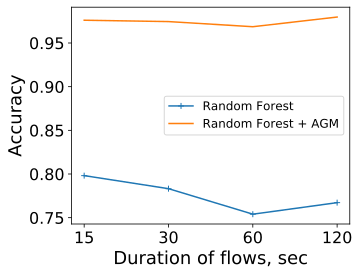

In [295]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
f, ax = plt.subplots(figsize=(5, 4))

ax.plot(x, comm_acc_B, '+', linestyle='solid', label='Random Forest')
ax.plot(x, agm_acc_B, '--', linestyle='solid', label='Random Forest + AGM')

plt.xlabel('Duration of flows, sec', size = 18);
plt.ylabel('Accuracy', size = 18);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

ax.legend(prop={'size': 12})
f.savefig("Hurst/AGMAccuracyB.png", bbox_inches = "tight")

plt.show()

In [60]:
data = arff.loadarff('Data_VPN/Scenario A1/TimeBasedFeatures-Dataset-15s-VPN.arff')
df = pd.DataFrame(data[0])

In [61]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [62]:
lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

In [63]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)


In [64]:
w_size = 500
a = 1
start_offset = 0
p = 0.1
X_new_full = GenerateNewFeaturesGM(X, start_offset, w_size, a, p)

(18500, 23)


100% |########################################################################|


In [65]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])
#X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps], 
#                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps])

In [66]:
RF = RandomForestClassifier(random_state=42)
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.9942342342342342


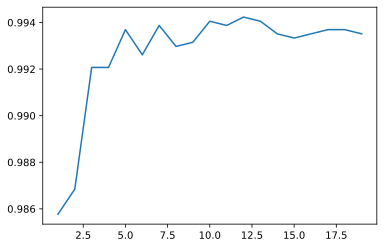

In [67]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

In [ ]:
X_tr120, X_t120, y_tr120, y_t120 = common_way ('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-120s-VPN.arff')
random_cv = random_search_cv(X_tr120, X_t120)
final_model = random_cv.best_estimator_
q120_common = model_quality(X_tr120, X_t120, y_tr120, y_t120, final_model)

In [57]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')
df = pd.DataFrame(data[0])

In [58]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [59]:
lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1 

In [46]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

In [29]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8704618689581095


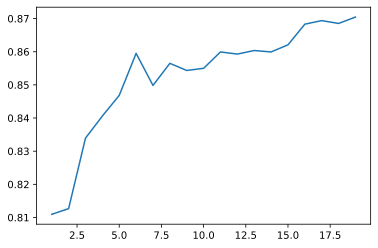

In [30]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# Hurst

In [31]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


In [32]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

In [33]:
RF = RandomForestClassifier(random_state=42)
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.973763440860215


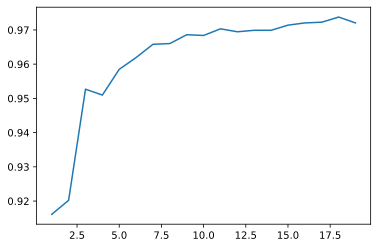

In [34]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# Generalized Mean 

In [37]:
def CalculateGM(y, a, N_steps, p):
    gm = np.zeros(N_steps)
    #progress = progressbar.ProgressBar()
    #for i in progress(range(0, N_steps)):
    #gm = np.power((1/(N_steps+1))*np.sum(np.power (y[0:N_steps], p)), 1/p)
    
    
    for i in range(0, N_steps):
        gm[i] = np.power((1/(i+1))*np.sum(np.power (y[0:i], p)), 1/p)
        if(math.isnan(gm[i])):
            print("Error!")
    
    return gm

In [38]:
def GenerateNewFeaturesGM(X, start_offset, w_size, a, p):
    N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
    L = N_steps * w_size
    #L = N_steps
    N_features = X.shape[1]
    X_new = np.zeros((L, N_features))
    print (X_new.shape)
    N_steps_window = int(np.floor(w_size / a))
    progress = progressbar.ProgressBar()
    for i in progress(range(0, N_features)):
        for j in range(0, N_steps):
            gm = CalculateGM(X[start_offset+j*w_size:start_offset+(j+1)*w_size, i], a, N_steps_window, p)
            #print(len(X.iloc[i*w_size:(i+1)*w_size, j]))
            #i_hurst = integral(hurst - np.mean(hurst))
            #X_new[j*w_size:(j+1)*w_size, i] = FirstDerivative(hurst)
            X_new[j*w_size:(j+1)*w_size, i] = gm
    return X_new

In [47]:
w_size = 500
a = 1
start_offset = 0
p = 0.1
X_new_full = GenerateNewFeaturesGM(X, start_offset, w_size, a, p)

(15500, 23)


100% |########################################################################|


In [48]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])
#X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps], 
#                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps])

In [49]:
RF = RandomForestClassifier(random_state=42)
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.9950537634408602


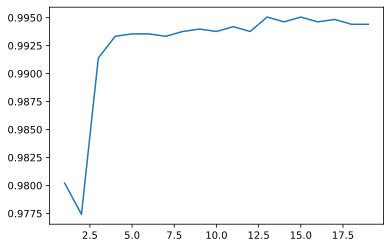

In [50]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

In [24]:
RF = RandomForestClassifier()
RF_pr = []
RF_rc = []
RF_f1 = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

print ("Pr",max(RF_pr)   ) 
print ("Rc",max(RF_rc))
print ("F1",max(RF_f1))

Pr 0.9954560760251422
Rc 0.9954107572844373
F1 0.9954333690666943


## Application classification 

In [157]:
data = arff.loadarff('Data_VPN/Scenario A2/TimeBasedFeatures-Dataset-15s-NO-VPN.arff')
df = pd.DataFrame(data[0])

In [158]:
df.head(1)

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,14993462.0,14993462.0,14967812.0,0.0,0.0,823486.0,854818.0,873.134288,287.914517,4612.743875,...,7050.781273,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,b'BROWSING'


In [159]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [160]:
y.value_counts()

b'VOIP'         2826
b'BROWSING'     2500
b'FT'           1018
b'P2P'          1000
b'CHAT'          890
b'STREAMING'     482
b'MAIL'          249
Name: class1, dtype: int64

In [136]:
#lb = preprocessing.LabelBinarizer()
#y_bin = np.zeros(len(y))
y_multi = np.zeros(len(y))

for i in range(0, len(y)):
    if y[i] == b'VPN-BROWSING':
        y_multi[i] = 0
    if y[i] == b'VPN-VOIP':
        y_multi[i] = 1 
    if y[i] == b'VPN-FT':
        y_multi[i] = 2 
    if y[i] == b'VPN-P2P':
        y_multi[i] = 3 
    if y[i] == b'VPN-CHAT':
        y_multi[i] = 4
    if y[i] == b'VPN-MAIL':
        y_multi[i] = 5
    if y[i] == b'VPN-STREAMING':
        y_multi[i] = 6     
    

In [137]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

#X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, 
                                                    #shuffle=True, stratify=y_bin)
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size = 0.3,random_state = 42, 
                                                    shuffle=True, stratify=y_multi)

In [138]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    #RF.fit(X_train, y_train.ravel())
    RF.fit(X_train, y_train)
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8713410483321987


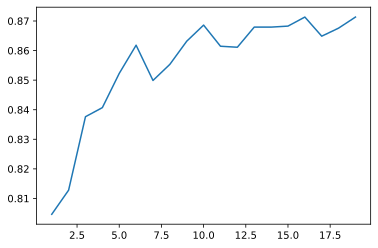

In [139]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# Differentiation of Sliding Rescaled Ranges.

In [37]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


In [38]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_multi[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_multi[0:N_steps*w_size])

In [39]:
RF = RandomForestClassifier(random_state=42)
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.9753846153846154


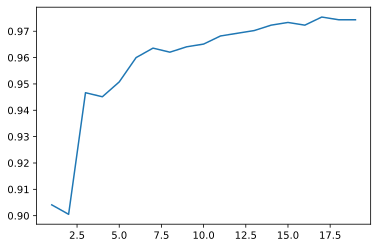

In [40]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# Accumulated Generalized Means

In [140]:
w_size = 500
a = 1
start_offset = 0
p = 0.1
X_new_full = GenerateNewFeaturesGM(X, start_offset, w_size, a, p)

(9500, 23)


100% |########################################################################|


In [141]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_multi[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_multi[0:N_steps*w_size])
#X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps], 
#                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps])

In [142]:
RF = RandomForestClassifier(random_state=42)
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.9936842105263158


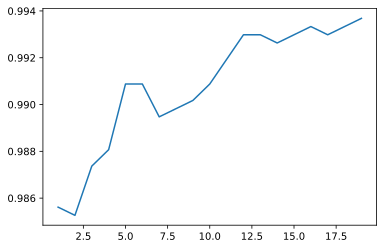

In [143]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

In [144]:
RF = RandomForestClassifier()
RF_pr = []
RF_rc = []
RF_f1 = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

print ("Pr",max(RF_pr)   ) 
print ("Rc",max(RF_rc))
print ("F1",max(RF_f1))

Pr 0.9932184421481481
Rc 0.993134408747164
F1 0.9931705007634687


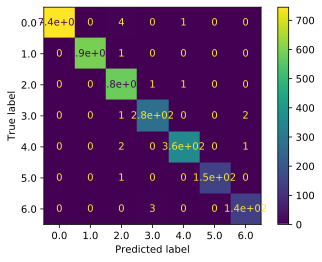

In [145]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(RF, X_test_full, y_test_full)  # doctest: +SKIP
plt.show()  # doctest: +SKIP